# Flow matching with conditioning

In the previous exercises, we trained a normalizing flow and a flow matching models to reproduce one distribution.

In this example, we will expand the concept a little bit and show that a single generative model can be trained to generate different distributions, by conditioning on additional variables.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from math import pi

## The data

We will use the swiss roll data distribution available from the `sklearn` library. This distribution generates samples in 3D, but we will only focus on a 2D projection, since the third dimension is not very interesting.

In [2]:
n_samples=1_000

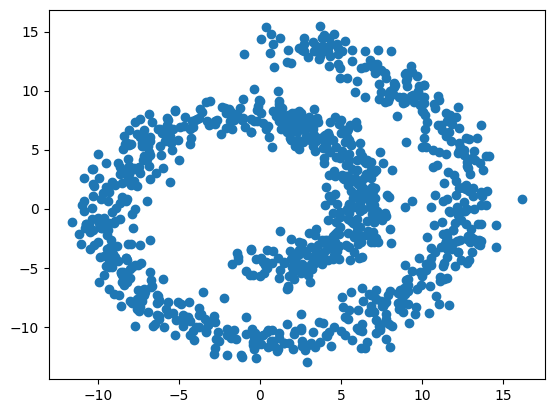

In [3]:
data, _ = make_swiss_roll(n_samples, noise=1)
data = data[:,[0, -1]]
fig=plt.scatter(data[:,0], data[:,1])

To show that generative models like flow matching can use other base distributions than the normal, we will also create a custom base distribution that samples values along a circle (a ring).

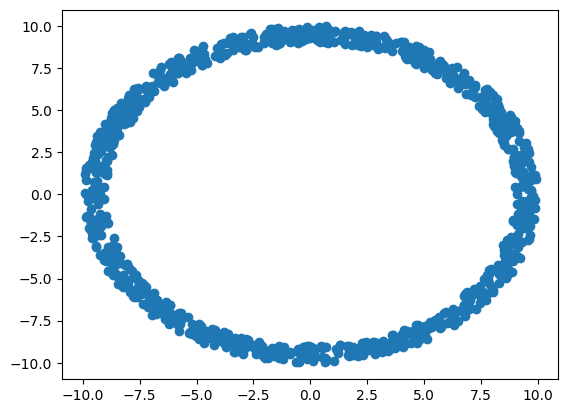

In [4]:
def make_ring(n_samples):
    u = np.random.uniform(low=0, high=2*pi, size=(n_samples,1))
    r = np.random.uniform(low=9, high=10, size=(n_samples,1))
    x = r * np.sin(u)
    y = r * np.cos(u)
    return np.concatenate([x, y], axis=-1)
    

base = make_ring(n_samples)
fig=plt.scatter(base[:,0], base[:,1])

## The model

The model is the same as in the datasaurus flow matching exercise *except* that the velocity network also accepts additional variables that we here call `condition`. This allows us to train the network to generate different distributions, depending on the values of `condition` that we choose.

In [5]:
class FlowMatching(keras.Model):
    def __init__(self, n_units, n_layers, dim=2):
        """ Initiate the flow matching model object

        Parameters
        ----------
        n_units: int
            Number of units per each layer of the velocity MLP
        n_layers: int
            Number of layers of the velocity MLP
        dim: int
            Number of output dimensions (by default 2 because the datasaurus lives in 2D)
        """
        super(FlowMatching, self).__init__()
        self.dim = dim
        self.velocity = keras.Sequential(
            [keras.layers.Dense(n_units, activation="elu") for _ in range(n_layers)]
            )
        self.velocity.add(keras.layers.Dense(dim))

    def call(self, inputs):
        """ Call the velocity vector

        Parameters
        ----------
        inputs: dict
            x_0: samples from the base distribution
            x_1: samples from the data distribution
            t:   samples of the time variable between [0, 1]
            condition: some conditioning variables


        Returns the velocity vector
        """
        x_0, x_1, t, condition = inputs.values()
        x_t = (1-t)*x_0 + t*x_1
        x = keras.ops.concatenate([x_t, t, condition], axis=-1)
        return self.velocity(x)

    def step(self, x, t, dt, condition):
        """ Make one step using the midpoint ODE solver

        Parameters
        ----------
        x: tensor/array (batch_size, dim)
            Samples of the variable x_t
        t: tuple/array (batch_size,)
            Samples of the time variable between [0, 1]
        dt: float
            The size of the time step
        condition: some conditioning variables

        Returns: tensor/array (batch_size, dim)
            Samples of the variable x_{t+dt}
        """

        t_start = np.zeros_like(x) + t
        input_start = keras.ops.concatenate([x, t_start, condition], axis=-1)
        v = self.velocity(input_start)
        x_mid = x + v * dt / 2

        t_mid = t_start + dt / 2
        input_mid = keras.ops.concatenate([x_mid, t_mid, condition], axis=-1)
        v = self.velocity(input_mid)
        x_end = x + v * dt

        return x_end

    def run(self, x, steps, condition):
        """ Run the ODE solver from t=0 to t=1

        Parameters
        ----------
        x: tensor/array (batch_size, dim)
            Samples from the base distribution, x_0
        steps: int
            Number of steps to make between t=0 and t=1
        condition: some conditioning variables
        
        Returns: tensor/array (batch_size, dim)
            Samples x_1 ~ p_1
        """

        time = np.linspace(0, 1, steps+1)
        output = []
        output.append(x)
        for i in range(steps):
            x = self.step(x, time[i], time[i+1]-time[i], condition)
            output.append(x)
        
        return output

    def sample(self, n_samples, steps, condition):
        """ Sample from the learned distribution

        Parameters
        ----------
        n_samples: int
            Number of samples to take
        steps: int
            Number of steps to make between t=0 and t=1 in the ODE
        condition: some conditioning variables

        Returns (array (batch_size, steps+1, dim)
            Samples of x_t ~ p_t
        """
        condition = np.array(condition)[np.newaxis,...]
        condition = np.repeat(condition, repeats=n_samples, axis=0)
        
        x_0 = make_ring(n_samples)
        x_1 = self.run(x_0, steps, condition)
        return np.array(x_1).swapaxes(0, 1)

Once we defined our model class, we can instantiate a new flow matching model object.

In [6]:
flow = FlowMatching(n_units=64, n_layers=8)

## Training

Similarly as in the datasaurus exercise, we will use a dataset object to do our sampling. Here, we will always generate a fresh batch of new data - from the swiss roll distribution, and from the ring distribution. 

We will also make a twist: We will randomly sample values of 1 or -1 for the x and y coordinate, which we use to scale the swiss roll data. This will produce 4 different variations of the swiss roll data, reflected along and $x$ or $y$ axis. The values of this scale will be passed to the velocity network as `condition`.

Otherwise, the rest is the same as with the datasaurus.

In [ ]:
class DataSet(keras.utils.PyDataset):
    def __init__(self, batch_size, n_batches):
        super().__init__()
        self.n_batches=n_batches
        self.batch_size = batch_size
    
    @property
    def num_batches(self):
        return self.n_batches

    def __getitem__(self, index):
        data, _ = make_swiss_roll(self.batch_size, noise=1)
        data=data[:,[0, -1]]
        
        condition=np.random.choice([1, -1], size=(batch_size, 2))
        data=condition * data

        base=make_ring(data.shape[0])
        
        t=np.random.uniform(low=0, high=1, size=data.shape[0])
        t=np.repeat(t[:,np.newaxis], repeats=data.shape[1], axis=1)

        target = data - base
        return dict(x_0=base, x_1=data, t=t, condition=condition), target

Next, we instantiate the dataset object, and define our schedule and optimizer, and compile the model.

In [8]:
epochs=20
batches=1000
batch_size=512

dataset=DataSet(batch_size=batch_size, n_batches=epochs*batches)

schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.01, decay_steps=epochs*batches)
optimizer = keras.optimizers.Adam(schedule, global_clipnorm=1.0)

flow.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError()
)

Again, the same as with the datasaurus exercise, we can call the `.fit` method to train the model.

In [9]:
history=flow.fit(x=dataset, epochs=epochs, steps_per_epoch=batches)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 67.5142
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 60.5823
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 59.2506
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 58.8516
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 58.4735
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 58.0877
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 57.6959
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 57.6651
Epoch 9/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 57.3689
Epoch 10/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 57.1357
Epoch 11/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 56.9357
Epoch 12/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 56.5468
Epoch 13/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 56.4292
Epoch 14/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 56.2061
Epoch 15/20
100

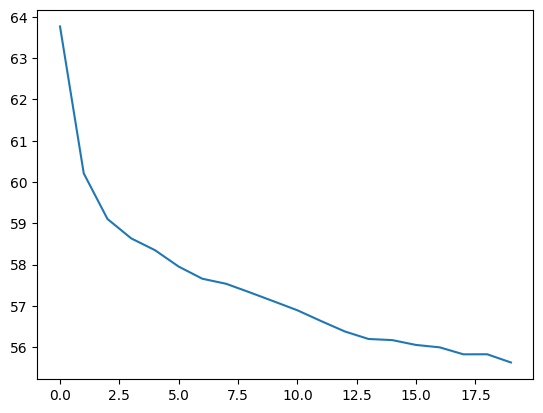

In [10]:
f=plt.plot(history.history["loss"])

Now that we fitted the model, let's see the samples it generates!

Here we will loop over the possible combinations of the `condition` which is either -1 or 1 for $x$ and $y$ coordinate - leading to 4 different distributions produced by the flow matching model.

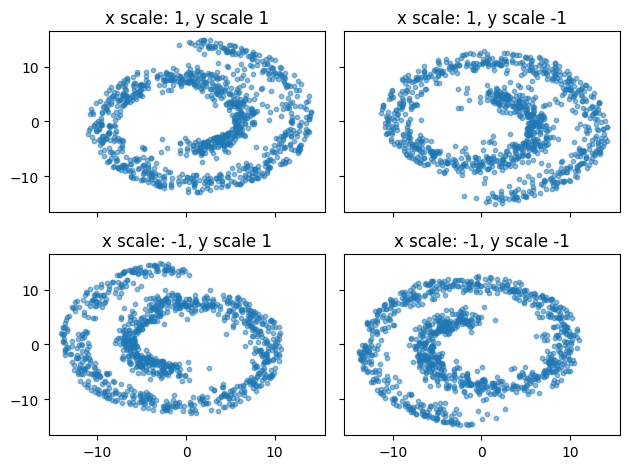

In [11]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
for i, x_scale in enumerate([1, -1]):
    for j, y_scale in enumerate([1, -1]):
        condition = [x_scale, y_scale]
        x = flow.sample(n_samples=n_samples, steps=100, condition=condition)
        axs[i,j].scatter(x[:, -1, 0], x[:, -1, 1], s=10, alpha=0.5)
        axs[i,j].set_title("x scale: {}, y scale {}".format(x_scale, y_scale))
fig.tight_layout()

## Further exercises

1. Here we only scaled the data by 2 values (-1 or 1) in two directions ($x$ and $y$). However, there is nothing that can stop us from using different values. Try to replace the line `condition=np.random.choice([1, -1], size=(batch_size, 2))` with some other transformation (for example, generate values from a uniform distribution between -1 and 1). What do you think the network will learn? Try it for yourself.
2. The swiss roll distribution generates 3D data. In this exercise, we only used 2 of the axes and neglected the third one. Try to change to model so that you can actually reproduce the swiss role in 3D (note: you will also need to change the base distribution to be 3D).